# Download Dataset

In [1]:
#!pip install roboflow
#!pip install torch
#!pip install torchvision

In [2]:
# Import the dataset
from roboflow import Roboflow
rf = Roboflow(api_key="dnZcw1fNasJT5SaFbDdG")
project = rf.workspace("vortexbuoytrainingset").project("buoy-detection-qzjg1")
version = project.version(1)
dataset = version.download("yolov11")

loading Roboflow workspace...
loading Roboflow project...


# Dataset Overview

In [3]:
from PIL import Image
import os
from collections import Counter

def check_image_dataset(directory_path, annotation_dir, target_dimensions=None):
    """
    Checks an image dataset for validity and optional dimension requirements,
    validates the corresponding annotation files in YOLO format, and counts
    occurrences of each label to detect potential imbalance.

    Args:
        directory_path (str): Path to the dataset directory containing images.
        annotation_dir (str): Path to the directory containing YOLO annotation files.
        target_dimensions (tuple): Optional. A tuple (width, height) to validate image dimensions.

    Returns:
        None
    """
    valid_images = 0
    invalid_images = 0
    label_count = 0
    missing_labels = 0
    label_frequencies = Counter()

    for root, dirs, files in os.walk(directory_path):
        for file in files:
            if file.lower().endswith(('jpg', 'jpeg', 'png', 'bmp', 'tif')):
                file_path = os.path.join(root, file)
                label_path = os.path.join(annotation_dir, os.path.splitext(file)[0] + '.txt')

                try:
                    # Open and validate image
                    with Image.open(file_path) as img:
                        if target_dimensions and img.size != target_dimensions:
                            print(f"   WARNING: Image dimensions {img.size} do not match target {target_dimensions}.")
                        img.verify()
                        valid_images += 1

                    # Validate label file
                    if os.path.exists(label_path):
                        with open(label_path, 'r') as label_file:
                            lines = label_file.readlines()
                            label_count += len(lines)

                            # Parse labels and update frequency count
                            for i, line in enumerate(lines):
                                parts = line.strip().split()
                                if len(parts) != 5:
                                    print(f"   ERROR: Invalid YOLO format in {label_path} on line {i + 1}: {line}")
                                else:
                                    label_class = parts[0]
                                    label_frequencies[label_class] += 1
                    else:
                        print(f"   WARNING: Missing label file for {file_path}")
                        missing_labels += 1

                except (IOError, SyntaxError) as e:
                    print(f"ERROR: {file_path} is invalid or corrupted. Error: {e}")
                    invalid_images += 1

    print("\nDataset Check Complete!")
    print(f" - Total valid images: {valid_images}")
    print(f" - Total invalid/corrupt images: {invalid_images}")
    print(f" - Total labels processed: {label_count}")
    print(f" - Missing label files: {missing_labels}")

    print("\nLabel Frequencies:")
    for label, count in label_frequencies.items():
        print(f" - Label {label}: {count} occurrences ({round(count/len(label_frequencies))}%)")

# Download Dataset

In [4]:
# Dataset image size 640x640
original_image_size = 640

# Train dataset
images_train_dir = "Buoy-Detection-1/train/images"
annotations_train_dir = "Buoy-Detection-1/train/labels"
check_image_dataset(images_train_dir, annotations_train_dir, target_dimensions=(original_image_size, original_image_size))


Dataset Check Complete!
 - Total valid images: 521
 - Total invalid/corrupt images: 0
 - Total labels processed: 521
 - Missing label files: 0

Label Frequencies:
 - Label 2: 130 occurrences (32%)
 - Label 0: 148 occurrences (37%)
 - Label 3: 132 occurrences (33%)
 - Label 1: 111 occurrences (28%)


In [5]:
# Test dataset
images_test_dir = "Buoy-Detection-1/test/images"
annotations_test_dir = "Buoy-Detection-1/test/labels"
check_image_dataset(images_test_dir, annotations_test_dir, target_dimensions=(original_image_size, original_image_size))


Dataset Check Complete!
 - Total valid images: 75
 - Total invalid/corrupt images: 0
 - Total labels processed: 75
 - Missing label files: 0

Label Frequencies:
 - Label 0: 21 occurrences (5%)
 - Label 3: 19 occurrences (5%)
 - Label 2: 19 occurrences (5%)
 - Label 1: 16 occurrences (4%)


In [6]:
# Validation dataset
images_valid_dir = "Buoy-Detection-1/valid/images"
annotations_valid_dir = "Buoy-Detection-1/valid/labels"
check_image_dataset(images_valid_dir, annotations_valid_dir, target_dimensions=(original_image_size, original_image_size))


Dataset Check Complete!
 - Total valid images: 148
 - Total invalid/corrupt images: 0
 - Total labels processed: 148
 - Missing label files: 0

Label Frequencies:
 - Label 0: 42 occurrences (10%)
 - Label 2: 37 occurrences (9%)
 - Label 1: 32 occurrences (8%)
 - Label 3: 37 occurrences (9%)


## Ploting some samples

In [7]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches

def plot_sample_with_bboxes(image_dir, label_dir, class_names, num_samples=5):
    """
    Plots samples from the dataset with bounding boxes and class labels.

    Args:
        image_dir (str): Path to the directory containing images.
        label_dir (str): Path to the directory containing YOLO annotations (labels).
        class_names (list): List of class names corresponding to class IDs.
        num_samples (int): Number of samples to plot.

    Returns:
        None
    """
    # Get list of image files
    image_files = [f for f in os.listdir(image_dir) if f.lower().endswith(('jpg', 'jpeg', 'png'))]
    if len(image_files) == 0:
        print("No images found in the specified directory.")
        return

    # Sample a few images
    sampled_images = image_files[:num_samples] if num_samples < len(image_files) else image_files

    for image_file in sampled_images:
        # File paths
        image_path = os.path.join(image_dir, image_file)
        label_path = os.path.join(label_dir, os.path.splitext(image_file)[0] + '.txt')

        # Load image
        with Image.open(image_path) as img:
            fig, ax = plt.subplots(1, 1, figsize=(5, 5))
            ax.imshow(img)
            ax.set_title(f"Image: {image_file}")

            # If label file exists, draw bounding boxes
            if os.path.exists(label_path):
                with open(label_path, 'r') as f:
                    for line in f:
                        parts = line.strip().split()
                        if len(parts) != 5:
                            print(f"Invalid label format in {label_path}. Skipping line: {line}")
                            continue
                        
                        # Parse YOLO annotation
                        class_id, x_center, y_center, width, height = map(float, parts)
                        class_name = class_names[int(class_id)] if int(class_id) < len(class_names) else f"Class {int(class_id)}"
                        
                        # Convert normalized YOLO bbox to pixel coordinates
                        img_width, img_height = img.size
                        x_center *= img_width
                        y_center *= img_height
                        width *= img_width
                        height *= img_height
                        
                        # Top-left corner
                        x_min = x_center - width / 2
                        y_min = y_center - height / 2
                        
                        # Draw rectangle
                        rect = patches.Rectangle((x_min, y_min), width, height, linewidth=2, edgecolor='green', facecolor='none')
                        ax.add_patch(rect)
                        ax.text(x_min, y_min - 5, class_name, color='green', fontsize=12, bbox=dict(facecolor='black', alpha=0.5))

            plt.show()

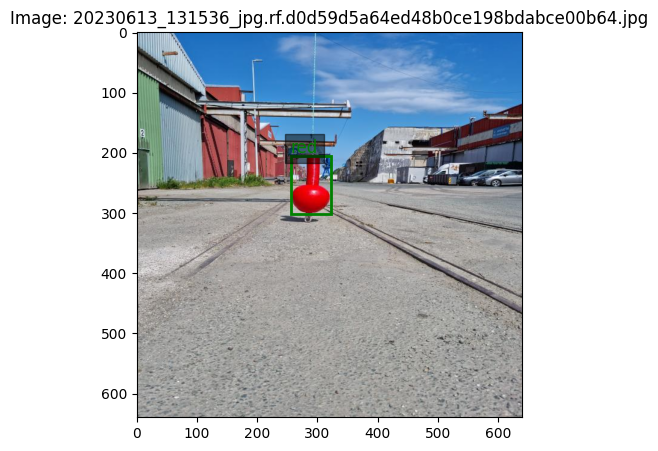

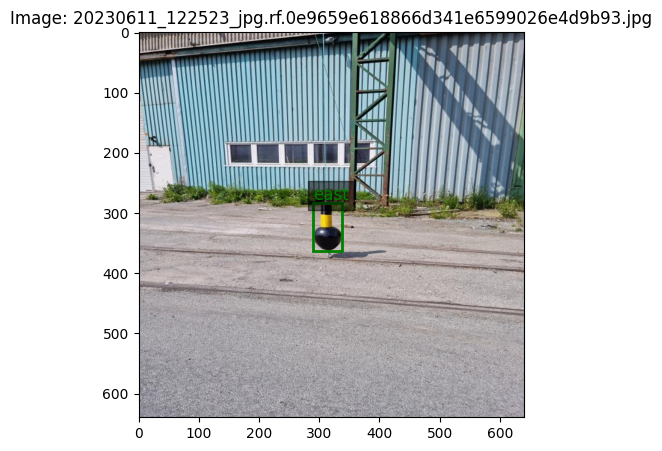

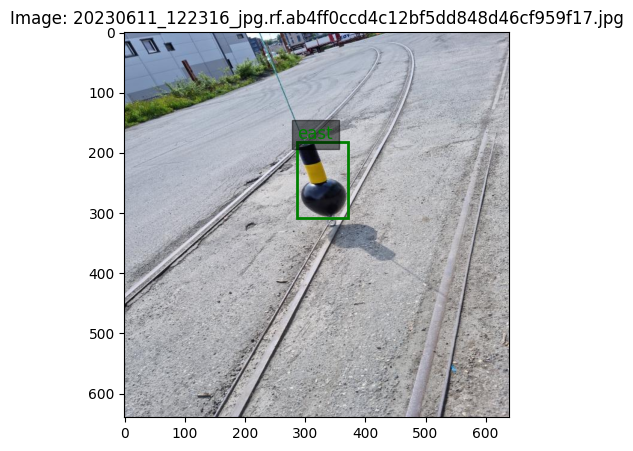

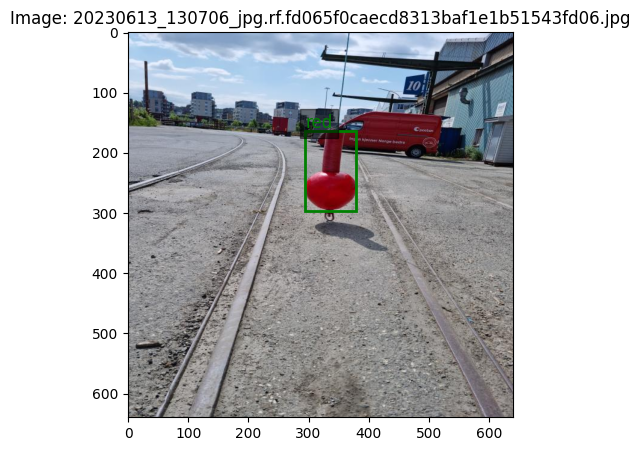

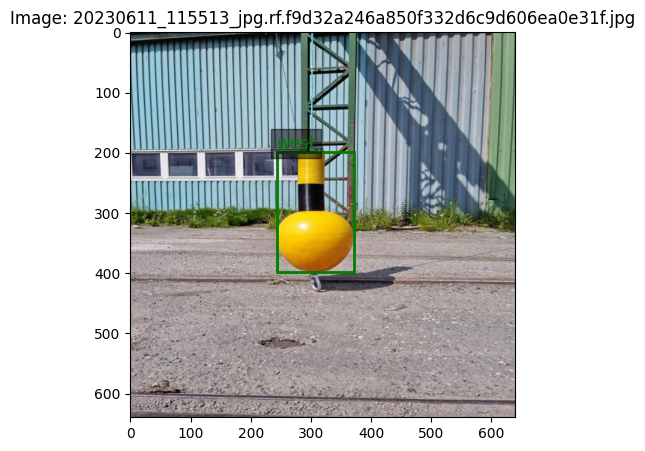

In [8]:
# Pass class names by index
class_names = ["east", "green", "red", "west"]  
plot_sample_with_bboxes(images_train_dir, annotations_train_dir, class_names, num_samples=5)

# Prepare Dataset

In [9]:
import os
import torch
from PIL import Image
from torch.utils.data import Dataset
import torchvision.transforms as transforms

class BuoyDataset(Dataset):
    def __init__(self, images_dir, annotations_dir, image_size, transform=None, original_image_size = 640):
        """
        Args:
            images_dir (str): Path to the folder containing buoy images.
            annotations_dir (str): Path to the folder containing YOLO-style annotations.
            image_size (int): Target size for resizing images (image_size x image_size).
            transform (callable, optional): Transformations for images.
        """
        self.images_dir = images_dir
        self.annotations_dir = annotations_dir
        self.image_size = image_size
        self.transform = transform

        # List all image files
        self.image_files = [f for f in os.listdir(images_dir) if f.endswith(('.jpg', '.png'))]

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        # Get image and corresponding annotation file
        img_file = self.image_files[idx]
        img_path = os.path.join(self.images_dir, img_file)
        annotation_path = os.path.join(self.annotations_dir, os.path.splitext(img_file)[0] + '.txt')

        # Load image
        image = Image.open(img_path).convert("RGB")
        if self.transform:
            image = self.transform(image)

        # Load and parse annotation
        with open(annotation_path, 'r') as f:
            lines = f.readlines()

        bboxes = []
        labels = []
        for line in lines:
            parts = line.strip().split()
            class_id = int(parts[0])
            x_center, y_center, width, height = map(float, parts[1:])

            # Convert normalized YOLO coordinates to pixel coordinates
            x_min = (x_center - width / 2)
            y_min = (y_center - height / 2)
            x_max = (x_center + width / 2) 
            y_max = (y_center + height / 2) 

            bboxes.append([x_min, y_min, x_max, y_max])
            labels.append(class_id)

        # Convert to tensors
        bboxes = torch.tensor(bboxes, dtype=torch.float32)
        labels = torch.tensor(labels, dtype=torch.long)

        return image, labels, bboxes

## Augmentations 

In [10]:
from torchvision.transforms import Compose, Resize, ToTensor, Normalize

batch_size = 128
img_resize = 128
# Define transforms
transform = Compose([
    Resize((img_resize, img_resize)),  # Resize images to a fixed size
    ToTensor(),          # Convert to PyTorch tensor
    Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5)),
])

# Train dataset
train_dataset = BuoyDataset(images_train_dir, annotations_train_dir, image_size=img_resize, transform=transform, original_image_size = original_image_size)
train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

# Test dataset
test_dataset = BuoyDataset(images_test_dir, annotations_test_dir, image_size=img_resize, transform=transform, original_image_size = original_image_size)
test_datalaoder = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# Valdiation dataset
valid_dataset = BuoyDataset(images_valid_dir, annotations_valid_dir, image_size=img_resize, transform=transform, original_image_size = original_image_size)
valid_dataloader = torch.utils.data.DataLoader(valid_dataset, batch_size=batch_size, shuffle=True)

In [11]:
# Check dataset length
print(train_dataset.__len__())
print(test_dataset.__len__())
print(valid_dataset.__len__())

521
75
148


In [12]:
# Check dataset image
idx = 0
print(train_dataset.__getitem__(idx)[0])
print(train_dataset.__getitem__(idx)[0].shape)

tensor([[[ 0.2392,  0.2157,  0.2392,  ..., -0.7412, -0.7490, -0.7490],
         [ 0.2392,  0.2314,  0.2314,  ..., -0.7412, -0.7490, -0.7490],
         [ 0.2157,  0.2235,  0.2392,  ..., -0.7412, -0.7412, -0.7412],
         ...,
         [ 0.2392,  0.1922,  0.1765,  ...,  0.2157,  0.1294,  0.1529],
         [ 0.2471,  0.2078,  0.2235,  ...,  0.0980,  0.1529,  0.2784],
         [ 0.0902,  0.2392,  0.2941,  ..., -0.0431,  0.0118,  0.1137]],

        [[ 0.4196,  0.3961,  0.4196,  ..., -0.1373, -0.1451, -0.1451],
         [ 0.4196,  0.4118,  0.4118,  ..., -0.1373, -0.1451, -0.1451],
         [ 0.4039,  0.4118,  0.4196,  ..., -0.1373, -0.1373, -0.1373],
         ...,
         [ 0.2549,  0.2078,  0.1922,  ...,  0.2157,  0.1294,  0.1529],
         [ 0.2627,  0.2235,  0.2314,  ...,  0.0980,  0.1529,  0.2784],
         [ 0.1059,  0.2549,  0.3020,  ..., -0.0431,  0.0118,  0.1137]],

        [[ 0.5451,  0.5216,  0.5451,  ...,  0.5059,  0.4980,  0.4980],
         [ 0.5451,  0.5373,  0.5373,  ...,  0

In [13]:
# Check dataset label
idx = 0
print(train_dataset.__getitem__(idx)[1])

tensor([2])


In [14]:
# Check dataset normalized Bounding Box
idx = 0
print(train_dataset.__getitem__(idx)[2])

tensor([[0.3996, 0.3215, 0.5035, 0.4707]])


## Model


In [15]:
import torch
import torch.nn as nn
from torchvision import models
import torch.nn.functional as F
from tqdm import tqdm

class VGG16BuoyDetector(nn.Module):
    def __init__(self, n_classes=4, pretrained=True, freeze_features=True):
        super().__init__()
        
        # Load pretrained VGG16
        vgg16 = models.vgg16(pretrained=pretrained)
        self.features = vgg16.features
        
        # Calculate features output size for 128x128 input
        # VGG16 has 5 max pooling layers, so spatial dimensions are divided by 2^5
        self.feature_output_size = (128 // 32) ** 2 * 512  # 128 is img_resize
        
        # Freeze feature layers if specified
        if freeze_features:
            for param in self.features.parameters():
                param.requires_grad = False
        
        # Shared fully connected layers
        self.shared_fc = nn.Sequential(
            nn.Linear(self.feature_output_size, 4096),
            nn.ReLU(True),
            nn.Dropout(p=0.5),
            nn.Linear(4096, 1024),
            nn.ReLU(True),
            nn.Dropout(p=0.5)
        )
        
        # Classification head
        self.classification_head = nn.Sequential(
            nn.Linear(1024, 512),
            nn.ReLU(True),
            nn.Dropout(p=0.3),
            nn.Linear(512, n_classes)
        )
        
        # Bounding box regression head
        self.bbox_head = nn.Sequential(
            nn.Linear(1024, 512),
            nn.ReLU(True),
            nn.Dropout(p=0.3),
            nn.Linear(512, 256),
            nn.ReLU(True),
            nn.Linear(256, 4)  # normalized x_min, y_min, x_max, y_max
        )
        
        self._initialize_weights()

    def forward(self, x):
        x = self.features(x)
        x = torch.flatten(x, 1)
        x = self.shared_fc(x)
        
        class_output = self.classification_head(x)
        bbox_output = self.bbox_head(x)
        bbox_output = torch.sigmoid(bbox_output)  # Ensure bbox coordinates are between 0 and 1
        
        return class_output, bbox_output
    
    def _initialize_weights(self):
        for module in [self.shared_fc, self.classification_head, self.bbox_head]:
            for m in module.modules():
                if isinstance(m, nn.Linear):
                    nn.init.xavier_uniform_(m.weight)
                    if m.bias is not None:
                        nn.init.constant_(m.bias, 0)

class BuoyDetectionLoss(nn.Module):
    def __init__(self, class_weight=1.0, bbox_weight=1.0):
        super().__init__()
        self.class_weight = class_weight
        self.bbox_weight = bbox_weight
        self.class_criterion = nn.CrossEntropyLoss()
        self.bbox_criterion = nn.SmoothL1Loss()

    def forward(self, class_pred, bbox_pred, class_target, bbox_target):
        class_loss = self.class_criterion(class_pred, class_target)
        bbox_loss = self.bbox_criterion(bbox_pred, bbox_target)
        
        total_loss = self.class_weight * class_loss + self.bbox_weight * bbox_loss
        return total_loss, class_loss, bbox_loss

## Train

In [16]:
def train_model(model, train_loader, valid_loader, criterion, optimizer, num_epochs, device):
    best_valid_loss = float('inf')
    
    for epoch in range(num_epochs):
        # Training phase
        model.train()
        train_losses = []
        
        for images, labels, bboxes in tqdm(train_loader, desc=f'Epoch {epoch+1}/{num_epochs}'):
            images = images.to(device)
            labels = labels.to(device)
            bboxes = bboxes.to(device)
            
            # Handle multiple objects: take first object for now
            labels = labels[:, 0]  # Take first object's class
            bboxes = bboxes[:, 0]  # Take first object's bbox
            
            optimizer.zero_grad()
            class_pred, bbox_pred = model(images)
            
            total_loss, class_loss, bbox_loss = criterion(
                class_pred, bbox_pred, labels, bboxes
            )
            
            total_loss.backward()
            optimizer.step()
            
            train_losses.append(total_loss.item())
        
        # Validation phase
        model.eval()
        valid_losses = []
        
        with torch.no_grad():
            for images, labels, bboxes in valid_loader:
                images = images.to(device)
                labels = labels.to(device)
                bboxes = bboxes.to(device)
                
                # Handle multiple objects: take first object for now
                labels = labels[:, 0]
                bboxes = bboxes[:, 0]
                
                class_pred, bbox_pred = model(images)
                total_loss, class_loss, bbox_loss = criterion(
                    class_pred, bbox_pred, labels, bboxes
                )
                valid_losses.append(total_loss.item())
        
        avg_train_loss = sum(train_losses) / len(train_losses)
        avg_valid_loss = sum(valid_losses) / len(valid_losses)
        
        print(f'Epoch {epoch+1}/{num_epochs}:')
        print(f'Average Training Loss: {avg_train_loss:.4f}')
        print(f'Average Validation Loss: {avg_valid_loss:.4f}')
        
        # Save best model
        if avg_valid_loss < best_valid_loss:
            best_valid_loss = avg_valid_loss
            torch.save({
                'epoch': epoch,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'best_valid_loss': best_valid_loss,
            }, 'best_buoy_detector.pth')

### Init Model

In [17]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")


# Initialize model with 4 classes
model = VGG16BuoyDetector(n_classes=4).to(device)

Using device: cuda


The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.


### Loss Criterium

In [18]:
criterion = BuoyDetectionLoss(class_weight=1.0, bbox_weight=1.0)

### Optmizer

In [19]:
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

### Train

In [ ]:
num_epochs = 500
train_model(model, train_dataloader, valid_dataloader, criterion, optimizer, num_epochs, device)

Epoch 1/1: 100%|██████████| 5/5 [00:15<00:00,  3.06s/it]


Epoch 1/1:
Average Training Loss: 10.1518
Average Validation Loss: 2.6675


## Evaluate

In [22]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from tqdm import tqdm
from torchvision.transforms import ToPILImage

def calculate_iou(box1, box2):
    """
    Calculate IoU between two bounding boxes
    boxes format: [x_min, y_min, x_max, y_max]
    """
    # Calculate intersection coordinates
    x_min = max(box1[0], box2[0])
    y_min = max(box1[1], box2[1])
    x_max = min(box1[2], box2[2])
    y_max = min(box1[3], box2[3])
    
    # Calculate intersection area
    if x_max <= x_min or y_max <= y_min:
        return 0.0
    
    intersection = (x_max - x_min) * (y_max - y_min)
    
    # Calculate union area
    box1_area = (box1[2] - box1[0]) * (box1[3] - box1[1])
    box2_area = (box2[2] - box2[0]) * (box2[3] - box2[1])
    union = box1_area + box2_area - intersection
    
    return intersection / union if union > 0 else 0.0

def evaluate_model(model, dataloader, criterion, device, iou_threshold=0.5):
    """
    Evaluate model performance
    """
    model.eval()
    total_loss = 0
    total_class_accuracy = 0
    total_iou = 0
    total_samples = 0
    class_correct = {i: 0 for i in range(4)}  # Assuming 4 classes
    class_total = {i: 0 for i in range(4)}
    
    all_ious = []  # Store all IoUs for distribution analysis
    
    with torch.no_grad():
        for images, labels, bboxes in tqdm(dataloader, desc="Evaluating"):
            images = images.to(device)
            labels = labels.to(device)
            bboxes = bboxes.to(device)
            
            # Take first object for single-object detection
            labels = labels[:, 0]
            bboxes = bboxes[:, 0]
            
            # Forward pass
            class_pred, bbox_pred = model(images)
            
            # Calculate losses
            total_loss_batch, class_loss, bbox_loss = criterion(
                class_pred, bbox_pred, labels, bboxes
            )
            
            # Calculate classification accuracy
            _, predicted = torch.max(class_pred.data, 1)
            correct = (predicted == labels).sum().item()
            total_class_accuracy += correct
            
            # Update per-class accuracy
            for i in range(len(labels)):
                label = labels[i].item()
                class_total[label] += 1
                if predicted[i].item() == label:
                    class_correct[label] += 1
            
            # Calculate IoU for each prediction
            for i in range(len(bboxes)):
                iou = calculate_iou(
                    bbox_pred[i].cpu().numpy(),
                    bboxes[i].cpu().numpy()
                )
                all_ious.append(iou)
                total_iou += iou
            
            total_samples += images.size(0)
            total_loss += total_loss_batch.item()
    
    # Calculate metrics
    avg_loss = total_loss / len(dataloader)
    avg_accuracy = total_class_accuracy / total_samples
    avg_iou = total_iou / total_samples
    
    # Calculate per-class accuracy
    class_accuracies = {
        class_id: class_correct[class_id] / class_total[class_id] 
        if class_total[class_id] > 0 else 0
        for class_id in class_total
    }
    
    # Calculate percentage of "good" detections (IoU > threshold)
    good_detections = sum(1 for iou in all_ious if iou > iou_threshold)
    detection_rate = good_detections / len(all_ious)
    
    return {
        'avg_loss': avg_loss,
        'avg_accuracy': avg_accuracy,
        'avg_iou': avg_iou,
        'class_accuracies': class_accuracies,
        'detection_rate': detection_rate,
        'all_ious': all_ious
    }

In [23]:
# Load trained model
model = VGG16BuoyDetector(n_classes=4).to(device)
checkpoint = torch.load('best_buoy_detector.pth')
model.load_state_dict(checkpoint['model_state_dict'])

# Create criterion
criterion = BuoyDetectionLoss()

# Evaluate on test set
print("Evaluating on test set...")
test_metrics = evaluate_model(model, test_datalaoder, criterion, device)

# Print metrics
print("\nTest Set Metrics:")
print(f"Average Loss: {test_metrics['avg_loss']:.4f}")
print(f"Average Accuracy: {test_metrics['avg_accuracy']:.4f}")
print(f"Average IoU: {test_metrics['avg_iou']:.4f}")
print(f"Detection Rate (IoU > 0.5): {test_metrics['detection_rate']:.4f}")
print("\nPer-class Accuracies:")
for class_id, accuracy in test_metrics['class_accuracies'].items():
    print(f"Class {class_id}: {accuracy:.4f}")

You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.


Evaluating on test set...


Evaluating: 100%|██████████| 1/1 [00:02<00:00,  2.07s/it]


Test Set Metrics:
Average Loss: 2.4426
Average Accuracy: 0.3067
Average IoU: 0.0106
Detection Rate (IoU > 0.5): 0.0000

Per-class Accuracies:
Class 0: 0.0000
Class 1: 0.0000
Class 2: 1.0000
Class 3: 0.2105


### Check Predictions

In [27]:
def denormalize_image(normalized_image):
    """
    Denormalize image from [-1, 1] to [0, 1] range
    Args:
        normalized_image: normalized image tensor with mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5)
    """
    mean = torch.tensor([0.5, 0.5, 0.5]).view(3, 1, 1)
    std = torch.tensor([0.5, 0.5, 0.5]).view(3, 1, 1)
    
    return normalized_image * std + mean

def visualize_predictions(model, dataloader, device, max_images=None):
    """
    Visualize model predictions with actual and predicted bounding boxes using original images
    """
    model.eval()
    
    # Get first batch
    images, labels, bboxes = next(iter(dataloader))
    batch_size = images.shape[0]
    
    # If max_images is specified, limit the number of images to show
    num_images = min(batch_size, max_images) if max_images else batch_size
    
    # Create figure and axes for subplots
    fig, axes = plt.subplots(num_images, 2, figsize=(15, 5*num_images))
    
    # Define colors for different classes
    class_colors = ['r', 'g', 'b', 'y']
    class_names = ['east', 'red', 'green', 'west']  # Replace with your class names
    
    with torch.no_grad():
        images = images.to(device)
        labels = labels[:, 0]  # Take first object
        bboxes = bboxes[:, 0]  # Take first object
        
        # Get predictions
        class_pred, bbox_pred = model(images)
        _, predicted_class = torch.max(class_pred.data, 1)
        
        for idx in range(num_images):
            # Get original image (denormalized)
            img_tensor = denormalize_image(images[idx].cpu())
            
            # Convert to numpy for matplotlib
            img_numpy = img_tensor.permute(1, 2, 0).numpy()
            
            # Clip values to [0, 1] range
            img_numpy = np.clip(img_numpy, 0, 1)
            
            # Plot original image with ground truth
            axes[idx, 0].imshow(img_numpy)
            axes[idx, 0].set_title(f'Ground Truth (Class: {class_names[labels[idx].item()]})')
            
            # Draw ground truth box
            true_box = bboxes[idx].cpu().numpy()
            true_rect = patches.Rectangle(
                (true_box[0] * img_numpy.shape[1], true_box[1] * img_numpy.shape[0]),
                (true_box[2] - true_box[0]) * img_numpy.shape[1],
                (true_box[3] - true_box[1]) * img_numpy.shape[0],
                linewidth=2,
                edgecolor=class_colors[labels[idx]],
                facecolor='none'
            )
            axes[idx, 0].add_patch(true_rect)
            
            # Plot image with predictions
            axes[idx, 1].imshow(img_numpy)
            
            # Draw predicted box
            pred_box = bbox_pred[idx].cpu().numpy()
            pred_rect = patches.Rectangle(
                (pred_box[0] * img_numpy.shape[1], pred_box[1] * img_numpy.shape[0]),
                (pred_box[2] - pred_box[0]) * img_numpy.shape[1],
                (pred_box[3] - pred_box[1]) * img_numpy.shape[0],
                linewidth=2,
                edgecolor=class_colors[predicted_class[idx]],
                facecolor='none'
            )
            axes[idx, 1].add_patch(pred_rect)
            
            # Calculate and display IoU
            iou = calculate_iou(true_box, pred_box)
            
            # Add confidence score for predicted class
            class_scores = torch.softmax(class_pred[idx], dim=0)
            predicted_score = class_scores[predicted_class[idx]].item()
            
            axes[idx, 1].set_title(
                f'Prediction (Class: {class_names[predicted_class[idx].item()]}, '
                f'Conf: {predicted_score:.2f}, IoU: {iou:.2f})'
            )
            
            # Remove axes
            axes[idx, 0].axis('off')
            axes[idx, 1].axis('off')
    
    plt.tight_layout()
    plt.show()


Generating visualization...


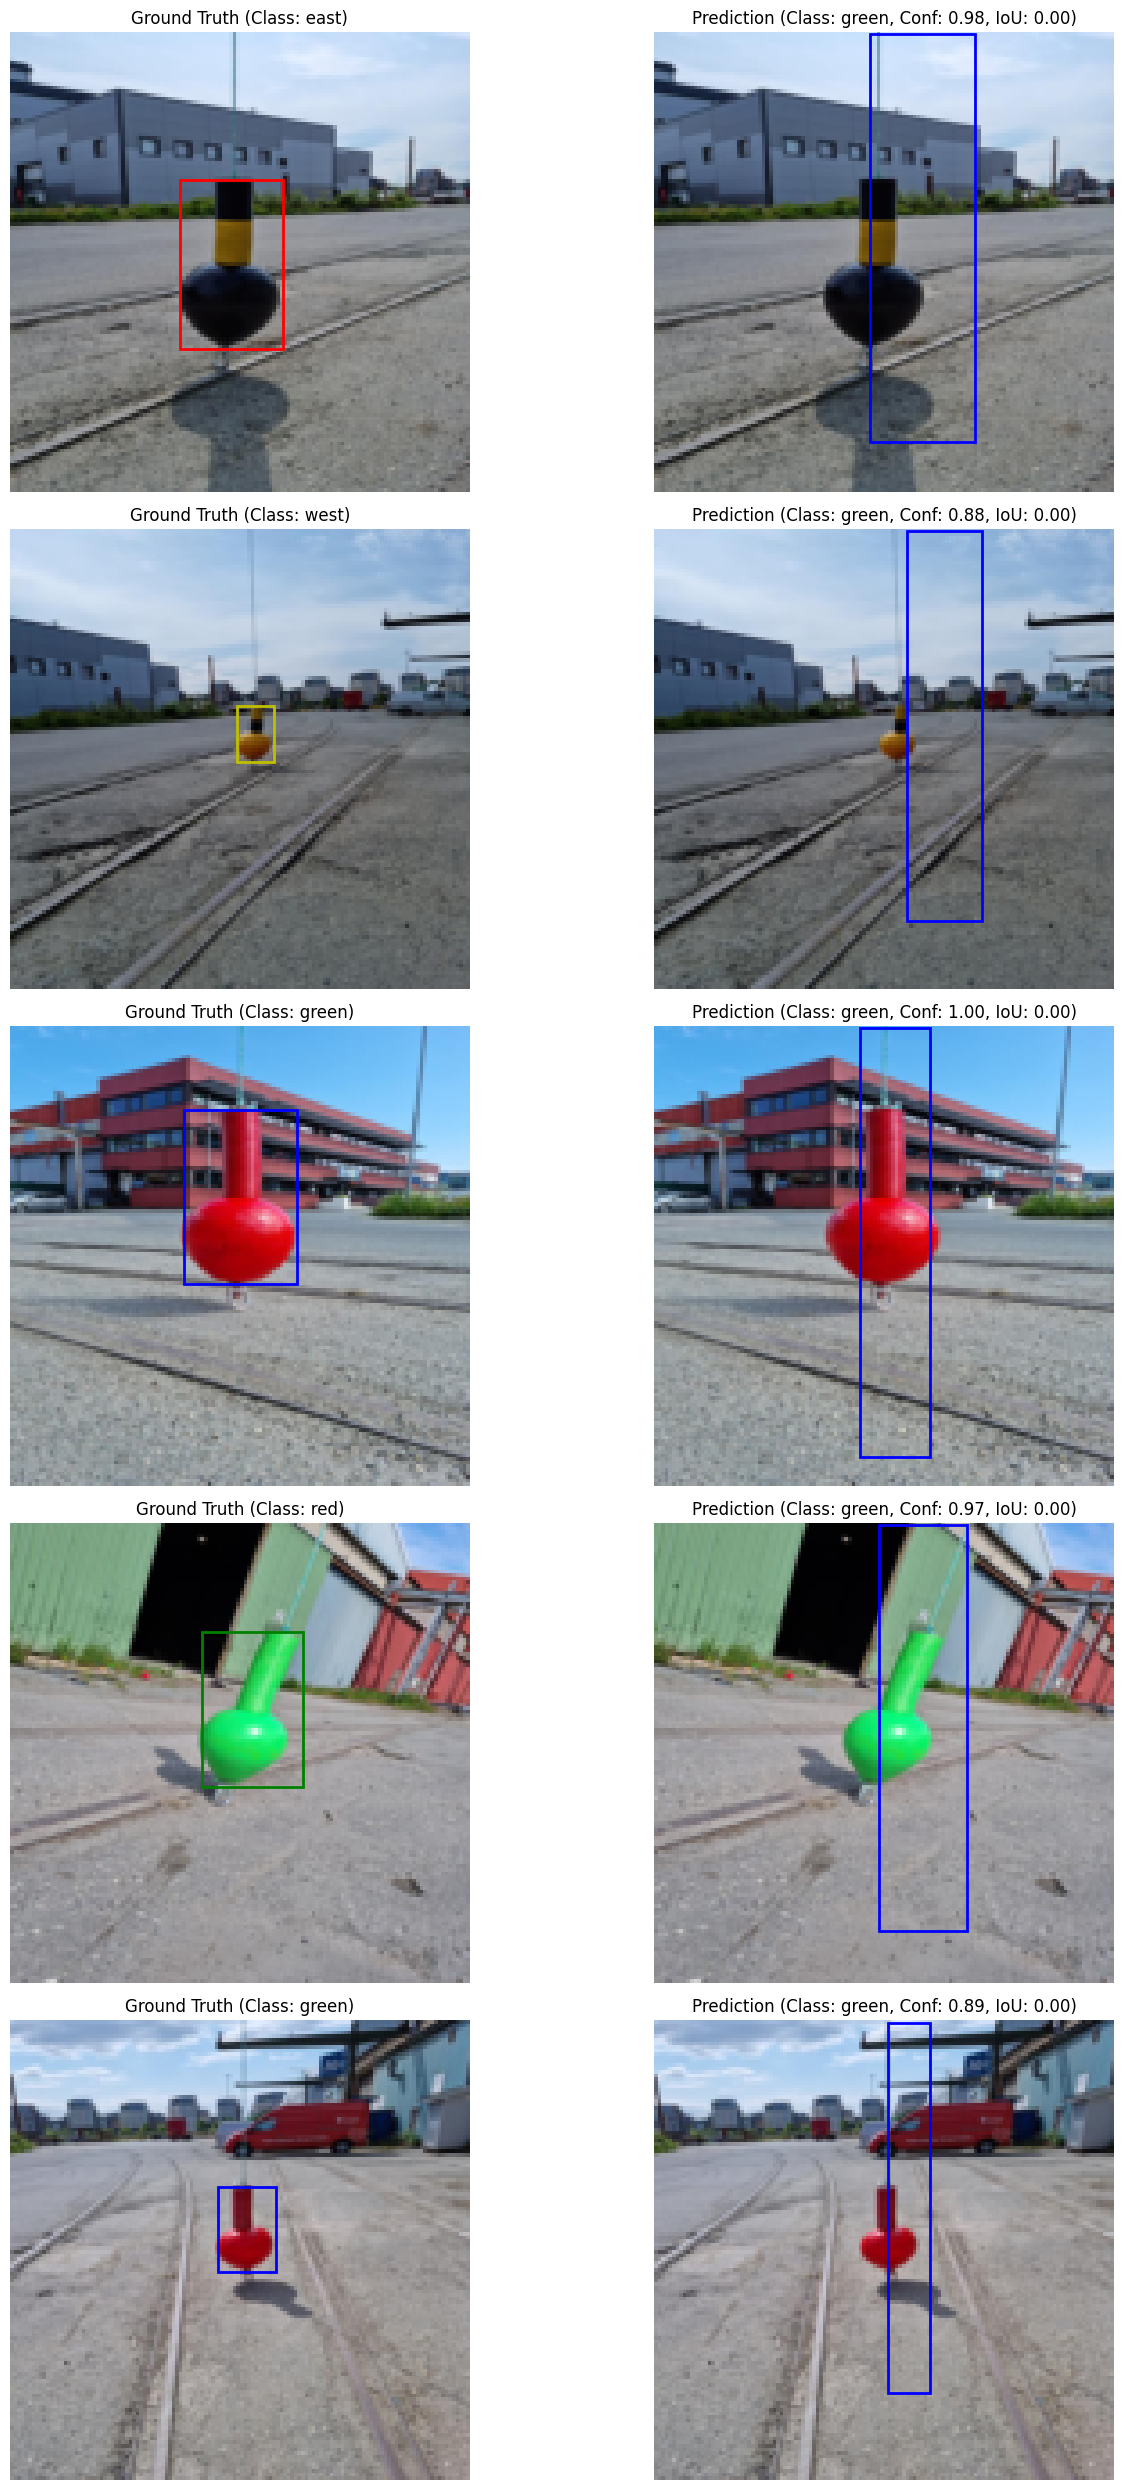

In [28]:
# Visualize predictions
print("\nGenerating visualization...")
visualize_predictions(model, test_datalaoder, device, max_images=5)

In [29]:
def plot_iou_distribution(iou_values, bins=50):
    """
    Plots the IoU distribution as a histogram.

    Args:
        iou_values (list or np.array): List of IoU values.
        bins (int): Number of bins for the histogram.

    Returns:
        None
    """
    plt.figure(figsize=(10, 6))
    plt.hist(iou_values, bins=bins, range=(0, 1), color='blue', alpha=0.7, edgecolor='black')
    plt.title('IoU Distribution', fontsize=16)
    plt.xlabel('IoU', fontsize=14)
    plt.ylabel('Frequency', fontsize=14)
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.axvline(x=0.5, color='red', linestyle='--', label='IoU Threshold (0.5)')
    plt.legend(fontsize=12)
    plt.tight_layout()
    plt.show()


Plotting IoU distribution...


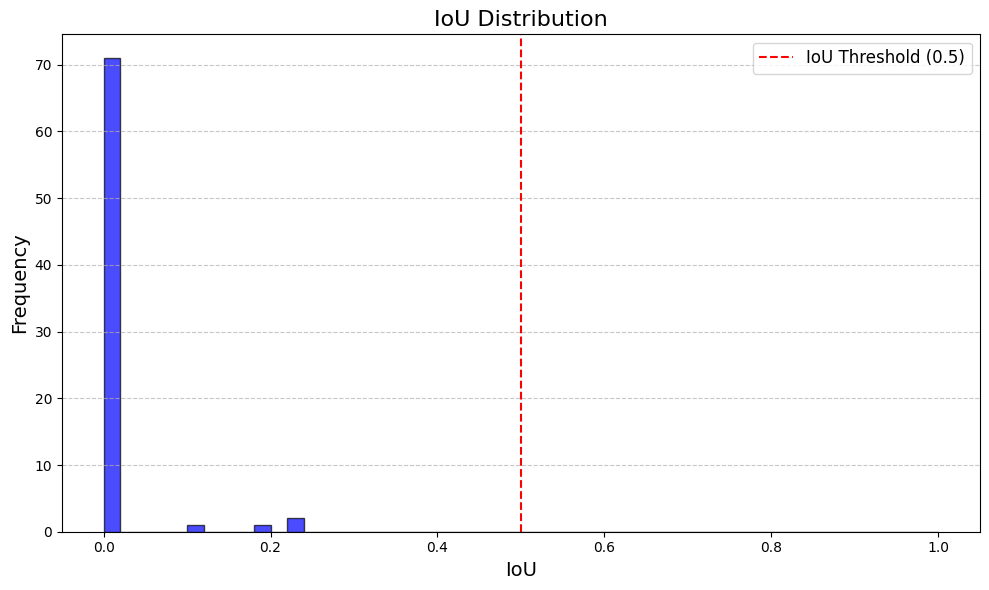

In [30]:
# Plot IoU distribution
print("\nPlotting IoU distribution...")
plot_iou_distribution(test_metrics['all_ious'])